/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Batch 1:
Sat Patches Shape: torch.Size([121, 3, 128, 128])
Map Patches Shape: torch.Size([121, 128, 128])


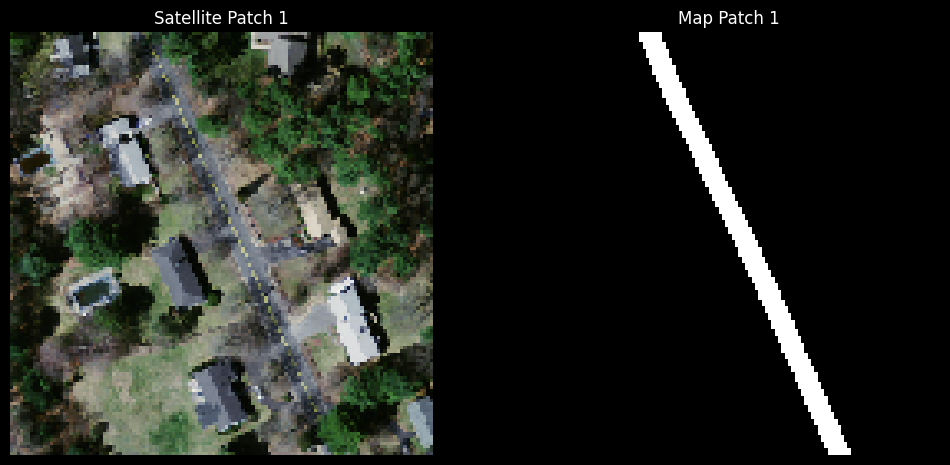

Batch 2:
Sat Patches Shape: torch.Size([147, 3, 128, 128])
Map Patches Shape: torch.Size([147, 128, 128])


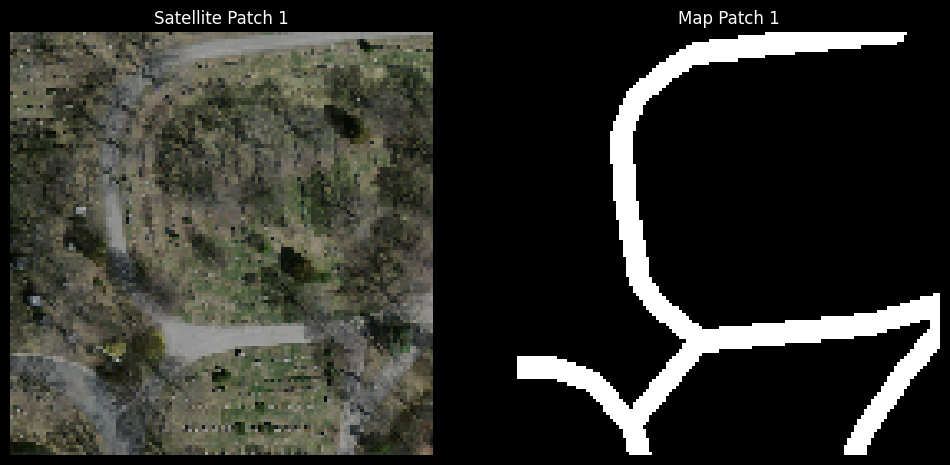

Batch 3:
Sat Patches Shape: torch.Size([81, 3, 128, 128])
Map Patches Shape: torch.Size([81, 128, 128])


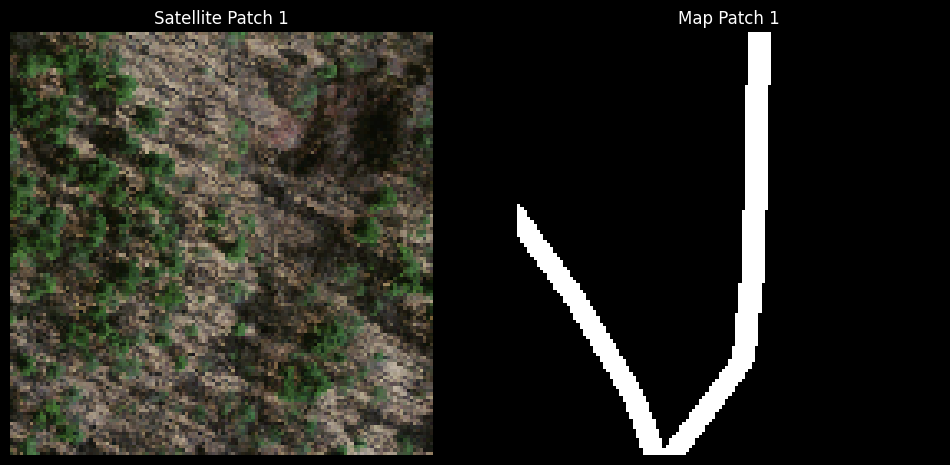

Batch 4:
Sat Patches Shape: torch.Size([142, 3, 128, 128])
Map Patches Shape: torch.Size([142, 128, 128])


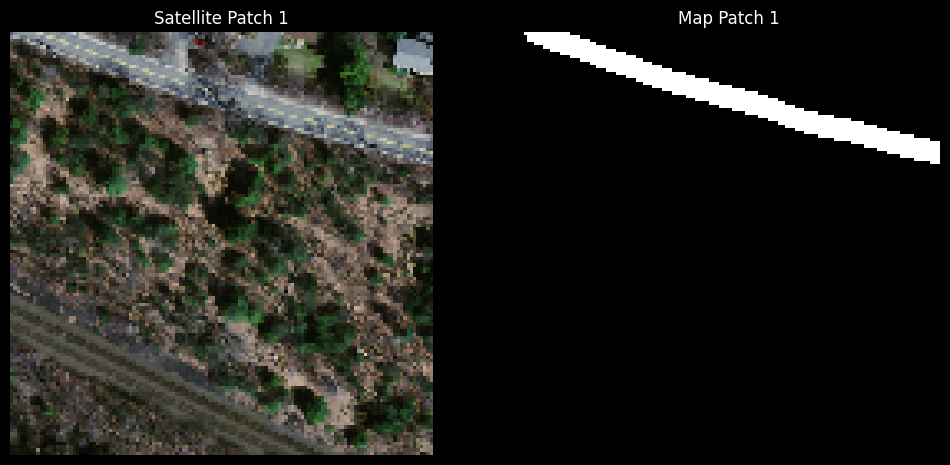

In [1]:
from torch.utils.data import DataLoader
from dataloaders.mass_roads_dataloader import MassRoadsDataset, custom_collate_fn
import matplotlib.pyplot as plt


data_dir = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'

train_dataset = MassRoadsDataset(root_dir=data_dir, split='train', window_size=128, stride=64)#, max_images=200)
test_dataset = MassRoadsDataset(root_dir=data_dir, split='test', window_size=128, stride=64)#, max_images=20)

dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)

def plot_patches(sat_patches, map_patches, n_patches=1):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i in range(min(n_patches, sat_patches.shape[0])):
        sat_patch = sat_patches[i].numpy().transpose(1, 2, 0) 
        map_patch = map_patches[i].numpy()

        ax[0].imshow(sat_patch)
        ax[0].set_title(f'Satellite Patch {i+1}')
        ax[0].axis('off')

        ax[1].imshow(map_patch, cmap='gray')
        ax[1].set_title(f'Map Patch {i+1}')
        ax[1].axis('off')

    plt.show()

for i, (sat_patches, map_patches) in enumerate(dataloader_train):
    print(f"Batch {i+1}:")
    print(f"Sat Patches Shape: {sat_patches.shape}")
    print(f"Map Patches Shape: {map_patches.shape}")

    plot_patches(sat_patches, map_patches, n_patches=1)
    if i > 2:
        break


In [ ]:
import os
import torch
import torch.optim as optim
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork
from torchvision import models
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
checkpoint_path = "./checkpoints/mulde_checkpoint.pth"

mlp_model = MLPs(input_dim=2048, output_dim=128*128, units=[4096, 4096])  # Change output_dim to H*W (128x128)
mulde_model = ScoreOrLogDensityNetwork(mlp_model, score_network=False)  # Using log-density network
mulde_model = mulde_model.to(device)

# Load pretrained ResNet50 and freeze the layers
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Identity()  # Remove the final classification layer
resnet = resnet.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()  # Use binary cross-entropy loss with logits
optimizer = optim.Adam(mulde_model.parameters(), lr=1e-4)  # Adam optimizer

# Load checkpoint if it exists
start_epoch = 0
best_loss = float('inf')
if os.path.exists(checkpoint_path):
    # checkpoint = torch.load(checkpoint_path, map_location=device)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    mulde_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    print(f"Resumed training from epoch {start_epoch}, best loss: {best_loss:.4f}")

num_epochs = 300

# Training loop
for epoch in range(start_epoch, num_epochs):
    mulde_model.train()  # Set model to training mode
    running_loss = 0.0

    for i, (sat_patches, map_patches) in tqdm(enumerate(dataloader_train), total=len(dataloader_train), desc=f"Epoch {epoch+1}/{num_epochs}"):
        if sat_patches.size(0) == 0 or map_patches.size(0) == 0:
            print(f"Skipping empty batch at index {i}")
            continue  # Skip the empty batch
        
        sat_patches = sat_patches.float().to(device)  # (batch_size, 3, H, W)
        map_patches = map_patches.float().to(device)  # (batch_size, H, W) - road map patches
        
        # Ensure the target map patches are of shape (batch_size, 1, H, W)
        map_patches = map_patches.unsqueeze(1)  # Add channel dimension: (batch_size, 1, H, W)

        # Extract features using ResNet (pretrained), and get a feature map of size (batch_size, 2048)
        features = resnet(sat_patches)  # Features shape: (batch_size, 2048)

        # Forward pass through MULDE network (score network or log-density network)
        outputs = mulde_model(features)  # Output shape: (batch_size, H*W)

        # Reshape the output to match the target shape: (batch_size, 1, H, W)
        outputs = outputs.view(-1, 1, 128, 128)  # Reshape to (batch_size, 1, H, W)

        # Calculate loss: BCEWithLogitsLoss expects outputs and targets to have the same shape
        loss = criterion(outputs, map_patches)  # (batch_size, 1, H, W) vs. (batch_size, 1, H, W)
        
        # Zero gradients, perform backward pass, and optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for the epoch
    avg_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save the checkpoint
    checkpoint = {
        'model_state_dict': mulde_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss
    }
    torch.save(checkpoint, checkpoint_path)

    # Save the model if it's the best loss so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(mulde_model.state_dict(), "mulde_model_best.pth")
        print("Best model saved.")


/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resumed training from epoch 100, best loss: 0.0804


Epoch 101/300:   0%|          | 0/1108 [00:00<?, ?it/s]/home/ri/miniconda3/envs/dl/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Epoch 101/300:   4%|▍         | 42/1108 [00:38<16:12,  1.10it/s]

In [ ]:
train_dataset = MassRoadsDataset(root_dir=data_dir, split='train', window_size=128, stride=64, max_images=700)
dataloader_train = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)

num_epochs = 50  # Number of epochs

# Training loop
for epoch in range(num_epochs):
    mulde_model.train()  # Set model to training mode
    running_loss = 0.0

    for i, (sat_patches, map_patches) in tqdm(enumerate(dataloader_train), total=len(dataloader_train), desc=f"Epoch {epoch+1}/{num_epochs}"):
        if sat_patches.size(0) == 0 or map_patches.size(0) == 0:
            print(f"Skipping empty batch at index {i}")
            continue  # Skip the empty batch
        
        sat_patches = sat_patches.float().to(device)  # (batch_size, 3, H, W)
        map_patches = map_patches.float().to(device)  # (batch_size, H, W) - road map patches
        
        # Ensure the target map patches are of shape (batch_size, 1, H, W)
        map_patches = map_patches.unsqueeze(1)  # Add channel dimension: (batch_size, 1, H, W)

        # Extract features using ResNet (pretrained), and get a feature map of size (batch_size, 2048)
        features = resnet(sat_patches)  # Features shape: (batch_size, 2048)
        # Forward pass through MULDE network (score network or log-density network)
        outputs = mulde_model(features)  # Output shape: (batch_size, H*W)

        # Reshape the output to match the target shape: (batch_size, 1, H, W)
        outputs = outputs.view(-1, 1, 128, 128)  # Reshape to (batch_size, 1, H, W)

        # Calculate loss: BCEWithLogitsLoss expects outputs and targets to have the same shape
        loss = criterion(outputs, map_patches)  # (batch_size, 1, H, W) vs. (batch_size, 1, H, W)
        
        # Zero gradients, perform backward pass, and optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average loss for the epoch
    avg_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Save the model if it's the best loss so far
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(mulde_model.state_dict(), "mulde_model_best.pth")


In [ ]:
torch.save(mulde_model.state_dict(), "mulde_model_last.pth")

In [ ]:
# Plot satellite images, ground truth, and predicted outputs
def plot_comparison(sat_images, ground_truths, predictions, num_samples=3):
    """
    Plots a few samples: Satellite image, Ground Truth map, and Predicted map
    """
    for i in range(num_samples):
        sat_img = sat_images[i][0]  # (C, H, W), select the first batch
        gt_map = ground_truths[i][0]  # (H, W), select the first batch
        pred_map = predictions[i][0]  # (H, W), select the first batch

        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot Satellite Image
        axes[0].imshow(np.transpose(sat_img, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
        axes[0].set_title("Satellite Image")
        axes[0].axis('off')
        
        # Plot Ground Truth Map
        axes[1].imshow(gt_map, cmap='gray')
        axes[1].set_title("Ground Truth Map")
        axes[1].axis('off')
        
        # Plot Predicted Map
        axes[2].imshow(pred_map, cmap='gray')
        axes[2].set_title("Predicted Map")
        axes[2].axis('off')
        
        plt.show()

# --- Call the function to plot comparisons ---
plot_comparison(sat_images, ground_truths, predictions, num_samples=2)


In [ ]:
# import torch
# import gc
# gc.collect()
# torch.cuda.empty_cache()
